# Pre-SN variability: short tutorial

Developed by Tobias Géron at the University of Toronto.

This code was developed to help better quantify detection thresholds with the Rubin pipelines. The current Rubin pipelines define detections with a simple SNR threshold. However, this becomes difficult when there is a bright background galaxy, or when the datapoint in question has a magnitude around the detection threshold (~23-24). How confident are we that this detection is real? This code was created with a specific science goal in mind: pre-SN variability. However, it can be used in any science context where you want to better understand the detection thresholds. We aim to answer the question: "Using the Rubin pipelines, in this specific epoch, using this specific template, how likely is it that a datapoint of X mag is detected?" 

This is answered using a series of source injection, image subtraction, and forced photometry. This is repeated for multiple injection locations and multiple magnitude ranges. The output of the pipeline is a recovery curve, which you can use to compute the 80% or 50% detection fraction thresholds (i.e. the magnitude where X% of sources with magnitude Y would be detected with the Rubin pipelines at this specific epoch and this specific template).

This is an short tutorial on how to use this package, where we only discuss the basics. For a more in-depth tutorial that covers and explains some of the logic behind the code, go to `tutorial.ipynb`. 

### Import packages, config, and some additional functions
Before we start, we must import everything we need. We use a lot of packages, both part of the LSST pipeline and others. We also define some additional functions to help generate simulated data to work on.

In [2]:
from pre_sn_variability import * # Import all functions

import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import pandas as pd
#from astropy.io import fits
#import scipy.stats as stats


# Various LSST pipelines
import lsst.afw.display as afwDisplay
from lsst.daf.butler import Butler
from lsst.rsp import get_tap_service

In [3]:
# Additional config
service = get_tap_service("tap")

butler_config = 'dp02'
collections = '2.2i/runs/DP0.2'
butler = Butler(butler_config, collections=collections)

afwDisplay.setDefaultBackend('matplotlib')

In [4]:
# Logging config

import logging

task_names = ['lsst.alardLuptonSubtract', 'lsst.visitInjectTask',
             'lsst.measurement']

for tn in task_names:
    logger = logging.getLogger(tn)
    logger.setLevel(logging.WARNING)  

'''
the different levels are DEBUG, INFO, WARNING, ERROR, CRITICAL
'''

'\nthe different levels are DEBUG, INFO, WARNING, ERROR, CRITICAL\n'

In [5]:
# Additional functions

def add_2009ip(target_mjd, target_dist = 100, target_peak = 61100, rescale = 1):
    '''
    Loads R band lightcurve of 2009ip. Rescales it to any distance. Output what flux (in nJy) would be at any MJD. 

    target_dist in Mpc
    target_peak in MJD

    Output in flux
    
    '''
    peak_2009ip = 56203 #MJD
    dist_2009ip = 24 #Mpc, luminosity distance
    
    df_2009ip = pd.read_csv('data/2009ip/2009ip.csv')
    df_2009ip['MJD'] -= peak_2009ip

    inds_keep = np.where((df_2009ip['MJD'] > -np.inf) & (df_2009ip['MJD'] < np.inf))[0] # Only keep +-100 days around SN.
    df_2009ip = df_2009ip.iloc[inds_keep].reset_index(drop=True)

    
    df_2009ip['MJD_adj'] = df_2009ip['MJD'] * rescale
    df_2009ip['MJD_adj'] = df_2009ip['MJD_adj'] + target_peak 
    df_2009ip['flux'] = mag_to_njy(df_2009ip['mag_R']) #nJy
    df_2009ip['flux_adj'] = df_2009ip['flux']*dist_2009ip**2 / target_dist**2 # Just solve F = L/(4pi * r **2) for the two different fluxes, and L1 = L2

    fluxes = np.interp(target_mjd, df_2009ip['MJD_adj'], df_2009ip['flux_adj'], left = 0, right = 0)
    return fluxes



def inject_data(calexp, template, coord_sn, coord_gal, mjd, rotation_angle, sn_peak = 61300, sn_dist = 130, 
                gal_path = 'data/ngc6308/ngc6308_cutout.fits', gal_mag = 13.844, band = 'g'):
    '''
    Takes a calexp and template image. Injects a galaxy in both, and a lightcurve of a SN in the calexp. Returns injected images. 
    '''

    ra_sn, dec_sn = coord_sn
    ra_gal, dec_gal = coord_gal 
    
    # Check if SN is in exposure
    if not in_exposure((ra_sn,dec_sn), calexp):
        print(f'Skipping {i} due to SN loc not in image...')
        return np.nan, np.nan
    
    # Inject the galaxy in calexp and template
    try:
          
        injection_catalog = create_injection_catalog([ra_gal],[dec_gal],['Stamp'],[gal_mag], 
                                                     stamp_loc = [gal_path], rotation = [rotation_angle])        
        calexp_inj, _ = inject_source(calexp, injection_catalog, band = band) 
        template_inj, _ = inject_source(template, injection_catalog, band = band)  
    except:
        print(f'Skipping {i} due to not being able to inject galaxy stamp...')
        return np.nan, np.nan

    

    # Inject 2009ip in calexp
    peak_flux = add_2009ip(mjd, target_dist = sn_dist, target_peak = sn_peak, rescale = 1)
    peak_mag = njy_to_mag(peak_flux) if peak_flux != 0 else np.inf
    if peak_mag < 40: # If it is fainter, dont't bother. Rubin pipelines sometimes seem to crash if you want to inject really faint stuff anyway
        injection_catalog = create_injection_catalog([ra_sn],[dec_sn],['Star'],[peak_mag])
        calexp_inj, _ = inject_source(calexp_inj, injection_catalog, band = band)

    return calexp_inj, template_inj

### Part 0: Create data

Note that this step is quite long, and can be skipped. We create artificial data (background galaxy + SN) that the pipelines can be used for. Once real data starts flowing in, this Part will be replaced with a real example. The end goal of this step is to create a science, template, difference image, as well as get a list of all the other sources in the image. If you just want to understand how the pipeline itself works, feel free to skip this step.

We select some ra/dec combination that is in DP0. We get the DatasetRef for every epoch this part of the sky was "observed" in DP0. We then store the information about each visit in `df_visit` (detector ids, visit ids, sky rotations, MJDs, ...). We then place a postage stamp of a known galaxy (NGC 6308) in every visit, as well as the light curve of SN 2009ip (a target that showed pre-SN activity). We place both at ~100 Mpc. We then use the Rubin pipelines to do image subtraction and forced photometry, so that we have a light curve of what SN 2009ip would have looked like at 100 Mpc, processed through the Rubin pipelines. We save the data in `df_exposure`. 

Note that we're not actually saving all the generated science, template and difference images themselves, due to memory constraints, but we have the information in df_visit to easily grab them again.

In [6]:
ra_gal, dec_gal = 56.622, -36.488
ra_sn, dec_sn = ra_gal + 3/60/60, dec_gal + 3/60/60 #offset by a few arcsec
band = 'r'

datasetRefs = butler.query_datasets("calexp", band=band, 
                                    where="visit_detector_region.region OVERLAPS POINT(ra, dec) "
                                    "AND visit_detector_region.region OVERLAPS POINT(ra_sn, dec_sn)",
                                    bind={"ra": ra_gal, "dec": dec_gal, "ra_sn": ra_sn, "dec_sn": dec_sn})

print(f"\nFound {len(datasetRefs)} calexps")


Found 131 calexps


In [7]:
# Get info from each visit. Especially the MJDs, as well as the sky rotation. 
df_visit = pd.DataFrame()

for datasetRef in tqdm(datasetRefs):
    visit_id = datasetRef.dataId['visit']
    
    query = "SELECT visit, skyRotation, expMidptMJD, band "\
            "FROM dp02_dc2_catalogs.Visit "\
            f"WHERE visit = {visit_id}"
    
    df_temp = service.search(query).to_table().to_pandas()
    df_visit = pd.concat([df_visit,df_temp])

# Add our detector ids
detector_ids = [datasetRef.dataId['detector'] for datasetRef in datasetRefs]
df_visit['detector'] = detector_ids

# Sort by mjd
df_visit = df_visit.sort_values(by='expMidptMJD').reset_index(drop=True)
mjd_min, mjd_max = np.min(df_visit['expMidptMJD']), np.max(df_visit['expMidptMJD'])

  0%|          | 0/131 [00:00<?, ?it/s]

In [8]:
# Remove duplicate days to make it clearer
df_visit['mjd_int'] = df_visit['expMidptMJD'].astype(int)
df_visit = df_visit[df_visit.duplicated(subset = 'mjd_int', keep = 'first') == False].reset_index(drop=True)
df_visit = df_visit.drop(columns=['mjd_int'])

In [9]:
# Randomly sample some datapoints. Will speed the rest up.
n_datapoints = 5
inds = np.random.choice(list(range(len(df_visit))), n_datapoints, replace=False)
df_visit = df_visit.iloc[inds]
df_visit = df_visit.sort_values(by='expMidptMJD').reset_index(drop=True)

In [10]:
df_visit.head()

,visit,skyRotation,expMidptMJD,band,detector
0,212070,62.275655,59867.214475,r,126
1,242597,159.295964,59914.194896,r,2
2,436538,45.557083,60206.284311,r,73
3,788843,151.900981,60740.056992,r,31
4,1155522,354.331158,61272.297119,r,46


In [11]:
plot = False

rows = [] #Collect the data in here

for i in tqdm(range(len(df_visit))):
    row = {} #Save all data here

    # Get the data
    visit = df_visit['visit'][i]
    detector = df_visit['detector'][i]
    dataId = {'visit': visit, 'detector': detector}
    
    calexp = butler.get('calexp', dataId=dataId)
    template = butler.get('goodSeeingDiff_templateExp', dataId=dataId)
    
    sources_calexp = butler.get('src', dataId=dataId)
    mjd = df_visit['expMidptMJD'][i]

    rotation_angle = df_visit['skyRotation'][i] 

    calexp_inj, template_inj = inject_data(calexp, template, (ra_sn, dec_sn), (ra_gal, dec_gal), mjd, rotation_angle, band = band)    
    if type(calexp_inj) != afwImage._exposure.ExposureF: #Sometimes the injection of the background galaxy/SNe is not successfull.
        continue
    
    # Create cutouts to speed things up.
    cutout_size = 1501 #in pixel units here
    calexp_inj = cutout_exposure(calexp_inj, ra_gal, dec_gal, size = cutout_size, size_units = 'pixel')
    template_inj = cutout_exposure(template_inj, ra_gal, dec_gal, size = cutout_size+20, size_units = 'pixel') #templates have a buffer region around edges. Need to account for that, hence the +20
    sources_calexp = filter_sources(sources_calexp, calexp_inj) #Only keep the sources that are actually also in the injected calexps cutout
    

    #  Subtract calexp and template to obtain diff
    diff_inj = subtract_images(template_inj, calexp_inj, sources = sources_calexp)


    
    if plot:
        fig, ax = plt.subplots(1,3, figsize=(15,5))

        plot_image_v2(calexp_inj, ax = ax[0], zoom_target = (ra_gal,dec_gal), zoom_size = 40, scale = 'asinh', vmin = 60,title = 'Science', plot_ticks = False, plot_colorbar = False, fontsize = 30, coords = (ra_sn, dec_sn))
        plot_image_v2(template_inj, ax = ax[1], zoom_target = (ra_gal,dec_gal), zoom_size = 40, scale = 'asinh', title = 'Template', plot_ticks = False, plot_colorbar = False, fontsize = 30, coords = (ra_sn, dec_sn))
        plot_image_v2(diff_inj.difference, ax = ax[2], zoom_target = (ra_gal,dec_gal), zoom_size = 40, scale = 'linear',title = 'Difference', plot_ticks = False, plot_colorbar = False, fontsize = 30, coords = (ra_sn, dec_sn))

        plt.suptitle(f'{mjd}')
        plt.tight_layout()
        plt.show()

    
    # Get forced photometry on difference image
    fp = forced_photometry(diff_inj.difference, [[ra_sn, dec_sn]])

    #Save data in row
    row['mjd'] = mjd
    row['visit'] = visit
    row['detector'] = detector
    row['sky_rotation'] = rotation_angle

    # Save forced photometry in instflux
    instflux_diff = fp['base_PsfFlux_instFlux'][0]
    instflux_err_diff = fp['base_PsfFlux_instFluxErr'][0]
    row['diff_psfInstFlux'] = instflux_diff
    row['diff_psfInstFluxErr'] = instflux_err_diff

    # Save forced photometry in flux (njy)
    njy_diff = instflux_to_njy(instflux_diff, diff_inj.difference)
    njy_err_diff = instflux_to_njy(instflux_err_diff, diff_inj.difference)
    row['diff_psfFlux'] = njy_diff
    row['diff_psfFluxErr'] = njy_err_diff

    # Save forced photometry in mags
    row['diff_psfMag'] = instflux_to_mag(instflux_diff, diff_inj.difference)
    row['diff_psfMagErr'] = njyerr_to_magerr(njy_err_diff, njy_diff)

    rows.append(row)


df_exposure = pd.DataFrame(rows)
df_exposure['detected'] = [True if df_exposure['diff_psfFlux'][i] - 5* df_exposure['diff_psfFluxErr'][i] > 0 else False for i in range(len(df_exposure))]
df_exposure['5sigma_mag'] = njy_to_mag(5* df_exposure['diff_psfFluxErr'])

  0%|          | 0/5 [00:00<?, ?it/s]

In [12]:
df_exposure.head()

,mjd,visit,detector,sky_rotation,diff_psfInstFlux,diff_psfInstFluxErr,diff_psfFlux,diff_psfFluxErr,diff_psfMag,diff_psfMagErr,detected,5sigma_mag
0,59867.214475,212070,126,62.275655,-818.539649,506.302407,-399.980380,247.405278,NaN,-0.671575,False,23.669053
1,59914.194896,242597,2,159.295964,-771.590080,461.027232,-377.475173,225.542472,NaN,-0.648730,False,23.769504
2,60206.284311,436538,73,45.557083,2087.342674,380.734445,1019.662887,185.988045,23.878858,0.198040,True,23.978862
3,60740.056992,788843,31,151.900981,3764.496752,676.971537,1877.081769,337.556655,23.216292,0.195249,True,23.331708
4,61272.297119,1155522,46,354.331158,49992.036444,564.504575,24529.712508,276.986815,20.425769,0.012260,True,23.546427


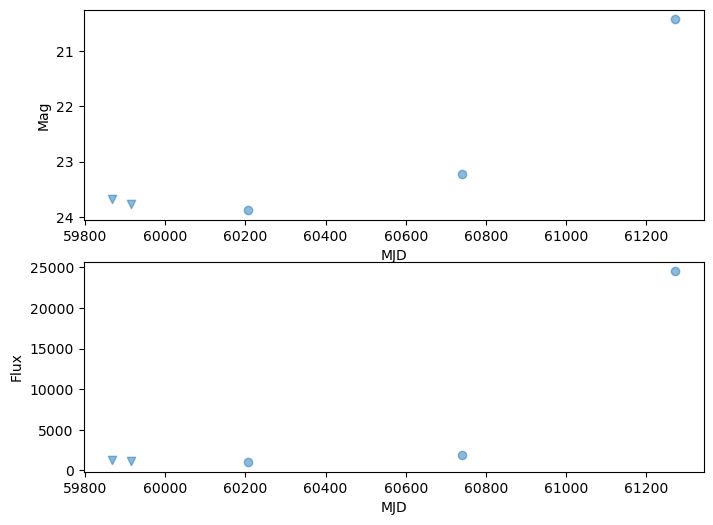

In [13]:
c = 'C0'

plt.figure(figsize = (8,6))
plt.subplot(2,1,1)
for i in range(len(df_exposure)):
        
    if df_exposure['detected'][i]: # A 5 sigma detection
        plt.scatter(df_exposure['mjd'][i], df_exposure['diff_psfMag'][i], c = c, alpha = 0.5)
    else:
        plt.scatter(df_exposure['mjd'][i], df_exposure['5sigma_mag'][i], marker = 'v', c = c, alpha = 0.5)
        

plt.gca().invert_yaxis()
plt.xlabel('MJD')
plt.ylabel('Mag')


plt.subplot(2,1,2)
for i in range(len(df_exposure)):
        
    if df_exposure['detected'][i]: # A 5 sigma detection
        plt.scatter(df_exposure['mjd'][i], df_exposure['diff_psfFlux'][i], c = c, alpha = 0.5)
    else:
        plt.scatter(df_exposure['mjd'][i], mag_to_njy(df_exposure['5sigma_mag'][i]), marker = 'v', c = c, alpha = 0.5)
        
plt.xlabel('MJD')
plt.ylabel('Flux')

plt.show()

Select one specific epoch to run the code on. 

In [14]:
i = 2

mjd = df_exposure['mjd'][i]
visit = df_exposure['visit'][i]
detector = df_exposure['detector'][i]
rotation_angle = df_exposure['sky_rotation'][i]
dataId = {'visit': visit, 'detector': detector}

# Get calexp, template and sources from butler
calexp = butler.get('calexp', dataId=dataId)
template = butler.get('goodSeeingDiff_templateExp', dataId=dataId)
sources_calexp = butler.get('src', dataId=dataId)

# Inject the galaxy and SN in the images
calexp, template = inject_data(calexp, template, (ra_sn, dec_sn), (ra_gal, dec_gal), mjd, rotation_angle, band = band)    

# Get the difference image
diff = subtract_images(template, calexp, sources = sources_calexp).difference

# Get the SN mag from df_exposure
sn_mag = df_exposure['diff_psfMag'][i] if df_exposure['detected'][i] else df_exposure['5sigma_mag'][i]

Visualse the target using `plot_image()`. Note that we do not show the whole images, just the section around the region of interested (finetuned with the `zoom_target` and `zoom_size` arguments).

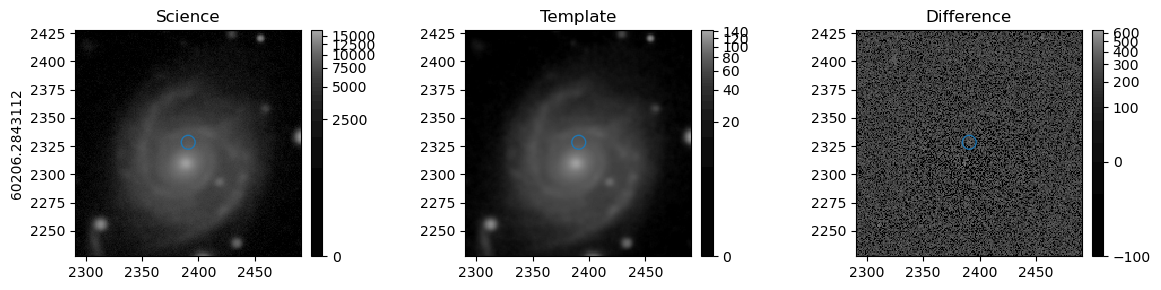

In [15]:
fig, ax = plt.subplots(1, 3, figsize=(12, 3))


plot_image(calexp, ax = ax[0], title = f'Science', plot_ticks = True, coords = (ra_sn,dec_sn), zoom_target = (ra_sn,dec_sn), zoom_size = 40, scale = 'asinh')
plt.ylabel(mjd)
plot_image(template, ax = ax[1], title = f'Template', plot_ticks = True, coords = (ra_sn,dec_sn), zoom_target = (ra_sn,dec_sn), zoom_size = 40, scale = 'asinh')
plot_image(diff, ax = ax[2], title = f'Difference', plot_ticks = True, coords = (ra_sn,dec_sn), zoom_target = (ra_sn,dec_sn), zoom_size = 40, scale = 'asinh')

plt.tight_layout()
plt.show()

Create cutouts of the images using `cutout_exposure()`. They will speed up some of the later code. Now we're all set to go.

In [17]:
cutout_size = 1501 #in pixel units here
calexp_cutout = cutout_exposure(calexp, ra_sn, dec_sn, size = cutout_size, size_units = 'pixel')
template_cutout = cutout_exposure(template, ra_sn, dec_sn, size = cutout_size+20, size_units = 'pixel') #templates have a buffer region around edges. Need to account for that, hence the +20
diff_cutout = cutout_exposure(diff, ra_sn, dec_sn, size = cutout_size, size_units = 'pixel')

### Part I: Estimate background noise

Before we continue, we need to talk about image subtraction. The subtraction pipeline is not perfect, it is a hard problem, especially when there is a bright background galaxy. Sometimes some pixels are registered as a detection (SNR > 5 in the difference image), even when there is not anything there. To investigate whether this is the case for your particular image, you can use `measure_snr_on_img()`.

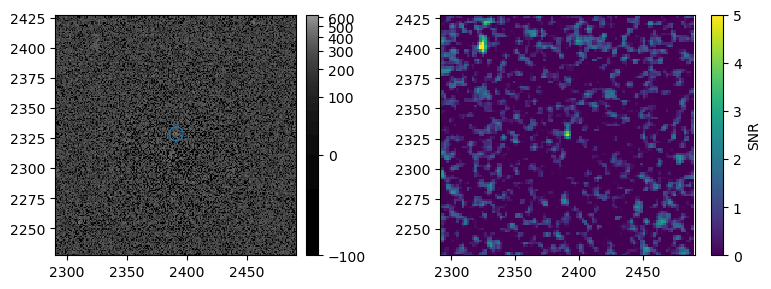

In [18]:
_ = measure_snr_on_img(diff_cutout, (ra_sn,dec_sn), zoom_size = 40, stepsize = 2, plot = True)


There can be a lot of detections at various places in this image, even when there shouldn't be. This isn't always the case, but typically happens when the background galaxy is very bright. This will affect both the original SN measurement made by the Rubin pipelines, as well as the measurements we make ourselves. We can estimate the contribution of this issue to the original SN measurement. This is done by finding all pixels that have similar flux values to the SN site in the template image, seeing what flux they have in the science image, and subtracting that from the SN flux. This is done with the `estimate_sn_background()` function. Ideally you want the background flux to be centered around zero. But if it isn't, then you can subtract the median from the sn mag.

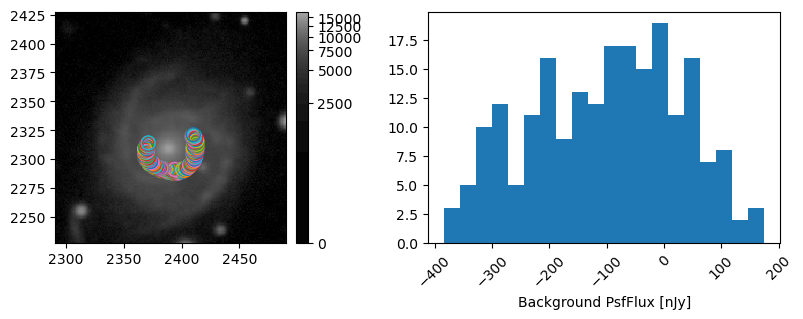

In [19]:
df_background = estimate_sn_background(calexp, template, sources = sources_calexp, sn_position = (ra_sn,dec_sn),
                             p_threshold = 5, plot = True)


# First convert SN magnitudes to nJy, then subtract median (or mean) of the background, then convert back to mag. 
sn_njy = mag_to_njy(sn_mag) - np.median(df_background['base_PsfFlux_nJy'])
sn_mag_new = njy_to_mag(sn_njy)

### Part II: Creating a recovery curve
We are almost there! The goal of this package is to generate a final recovery curve. We can do that by calling the `recovery_curve()` function. 

This function needs the sn_mag, the science exposure, the template exposure, the other sources in the image and the SN position as inputs. Additional settings can be adjusted through the `recovery_curve_config` class. 

There are a lot of settings that can be tweaked, but we'll go through some important ones here. A complete list of the parameters can be found in the readme. The `recovery_curve()` fuction creates a range of sn magnitudes to check. It is important to sample the transition region where the detection fraction goes from 1 to 0. This is done in different steps defined by the `n_mag_steps`. E.g., if n_mag_steps == [4,10], it'll first sample 4 magnitudes. It'll then zoom further in and sample 10 magnitudes in the next iteration. The default is [4,4,4,8,20]. This means it'll first sample 4 magnitudes, then zoom in and sample another 4, then another 4, another 8, and finally 20. The precision on the detection fraction depends on `n_injections`. If n_injections = 10, then we will only be precise with steps of 0.1 (i.e. 1/n_injections). The default is 10. Additionally, `cutout_size` determines the size of the cutout. As discussed above, smaller cutouts significantly speed things up, but we still need enough sources in the image to properly do the subtraction. The default option is to not use a cutout, but we strongly suggest to change this to your needs. Here a cutout_size of 300 arcsec seems to do the job. Additionally, as covered above, the subtraction pipeline doesn't always work perfectly. Some injection locations will always register as detections. We can account for that using the `subtract_background` parameter (default is True). If enabled, we first measure the baseline background before injecting fake sources and then subtract that from the measured value before determining whether the injected source is detected. Finally, the `n_jobs` parameter is used to parallelise the code. It should not exceed the number of available CPU cores.

Running this might take a few minutes per epoch. The `n_mag_steps`, `n_injection`, `cutout_size` and `n_jobs` parameters are the most important arguments to finetune if the pipeline takes too long. The biggest time sink is the Rubin image subtraction. Unfortunately, the nature of the pipeline requires us to use that, so we cannot make any improvements there. 

The `recovery_curve()` function returns a Pandas DataFrame where every row represents a injected source with magnitude `sn_mag`. The DataFrame contains a bunch of information. But most importantly, it contains a column with what fraction of these injections are recovered (`detected`).

Finally, it is good practise to pass the complete images you obtain from Rubin. We create cutouts within the function where appropriate. This also ensures that the wcs of each image behaves as expected.

Note that this may take a while to run. 

  0%|          | 0/5 [00:00<?, ?it/s]

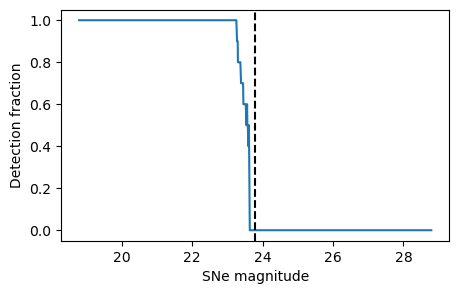

In [27]:
config = recovery_curve_config()
config.plot = True
config.n_injection = 10 
config.n_mag_steps = [4,4,4,8,20]
config.cutout_size = 300 # Strongly encouraged to add cutout size. 
config.n_jobs = 4 # Assuming we have 4 cores available

df_recovery = recovery_curve(sn_mag = sn_mag_new, science_exposure = calexp, template_exposure = template, 
                sources = sources_calexp, sn_position = (ra_sn,dec_sn), config = config)

In [28]:
df_recovery.head()

,sn_mag,base_PsfFlux_instFlux,base_PsfFlux_instFluxErr,base_PsfFlux_SNR,detected,background_nonzero_flag
0,18.789860,227170.663922,910.210299,250.279785,1.0,0.0
1,22.123193,10558.556168,612.721215,17.445250,1.0,0.0
2,22.456527,7809.434961,608.005179,13.013213,1.0,0.0
3,22.789860,5732.833746,604.382473,9.609383,1.0,0.0
4,23.123193,4199.959833,601.697334,7.073355,1.0,0.0


We can then estimate any detection threshold from the recovery curve (typically the 50% or the 80% detection fraction). This is done as follows:

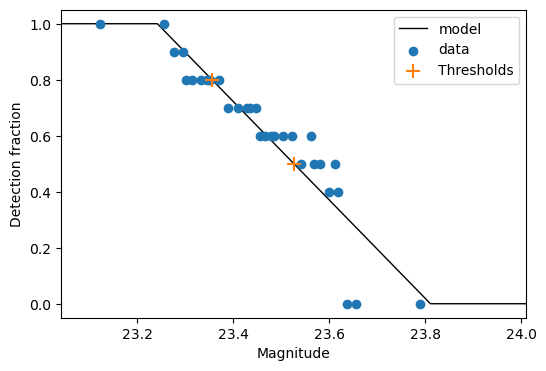

{'lim_0.5': 23.526450156447197, 'lim_0.8': 23.355704424174863}


In [29]:
mag_limits = find_thresholds(df_recovery,detection_fraction_thresholds = [0.5,0.8], plot = True)
print(mag_limits)

We can then compare these values to the sn magnitude to decide whether we trust it. 

In [30]:
sn_mag_new

23.78985995982773

For a more in-depth tutorial, please see `tutorial.ipynb`.